# Starbucks Promotion Segmentation - Segmentation

## Contents

### [Section I: Dependencies and Data](#load)
### [Section II: Quantile Segmentation - Frequency, Monetary, Tenure](#rfmt)
  ##### [1. User FMT - frequency, monetary value, and tenure](#rfmt1)
  ##### [2. FMT segmentation](#rfmt2)
  ##### [3. Completion rate of customer tiers](#rfmt3)
  ##### [4. Customer tier demographics](#rfmt4)
### [Section III: Cluster Segmentation](#clus)
  ##### [1. Principal component analysis (PCA)](#clus1)
  ##### [2. K-means clustering](#clus2)
  ##### [3. Cluster demographics](#clus3)
  ##### [4. Completion rate of clusters](#clus4)
### [Section IV: Summary](#summ)

## Introduction


This notebook continues from the previous notebook (`1-analysis.ipynb`). Here, we will attempt to discover the different demographic groups of users that share similar behavior on the Starbucks mobile app. I will be using the following methods:


1. `FMT segmentation` (frequency, monetary value, tenure) - group users into quantiles for each of these metrics and score customers using all 3 quantile features, then segments will be created based on the total scores
    - Frequency - how often the user made a transaction
    - Monetary value - how much money the user spent
    - Tenure - how long the user has been using the app
    - This is normally RFM (recency, frequency, monetary value), but recency is not useful here with only 1 month of activity data, so tenure is replacing recency
    

2. `K-means clustering`  - group users into clusters based on demographic and FMT features

## <a id="load">Section I: Dependencies and data</a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as subplots
sns.set()

import gc
import joblib
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans

# Data
profile = pd.read_pickle('../data/out1/profile.pkl')
transcript = pd.read_pickle('../data/out1/transcript.pkl')
offers = pd.read_pickle('../data/out1/offers.pkl')
profile.shape, transcript.shape, offers.shape

((14825, 10), (272388, 7), (148431, 26))

In [2]:
print(profile.info())
profile.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 0 to 14824
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   gender        14825 non-null  object        
 1   age           14825 non-null  int64         
 2   income        14825 non-null  int64         
 3   user_id       14825 non-null  int64         
 4   signup_date   14825 non-null  datetime64[ns]
 5   signup_year   14825 non-null  int64         
 6   age_group     14825 non-null  int64         
 7   income_group  14825 non-null  int64         
 8   amount        14825 non-null  float64       
 9   spend_group   14825 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(7), object(1)
memory usage: 1.2+ MB
None


gender  age  income  user_id signup_date  signup_year  age_group  \
0      F   55  112000        1  2017-07-15         2017          3   
1      F   75  100000        2  2017-05-09         2017          5   

   income_group  amount  spend_group  
0             5   77.01            5  
1             5  159.27            8

In [3]:
print(transcript.info())
transcript.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272388 entries, 0 to 272387
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   index     272388 non-null  int64  
 1   event     272388 non-null  object 
 2   time      272388 non-null  int64  
 3   amount    272388 non-null  float64
 4   offer_id  272388 non-null  int64  
 5   reward    272388 non-null  int64  
 6   user_id   272388 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 14.5+ MB
None


index           event  time  amount  offer_id  reward  user_id
0      0  offer received     0     0.0         7       0        2
1      2  offer received     0     0.0         5       0        3

In [4]:
print(offers.info())
offers.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148431 entries, 0 to 148430
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   index         148431 non-null  int64         
 1   event         148431 non-null  object        
 2   time          148431 non-null  int64         
 3   offer_id      148431 non-null  int64         
 4   user_id       148431 non-null  int64         
 5   amount        148431 non-null  float64       
 6   reward        148431 non-null  int64         
 7   difficulty    148431 non-null  int64         
 8   duration      148431 non-null  int64         
 9   offer_type    148431 non-null  object        
 10  mobile        148431 non-null  int64         
 11  social        148431 non-null  int64         
 12  web           148431 non-null  int64         
 13  expire_time   148431 non-null  int64         
 14  oid_uid       148431 non-null  object        
 15  viewed        148

index           event  time  offer_id  user_id  amount  reward  difficulty  \
0      0  offer received     0         7        2     0.0       5           5   
1      2  offer received     0         5        3     0.0       2          10   

   duration offer_type  ...  completed  group  gender  age  income  \
0         7       bogo  ...          1      4       F   75  100000   
1         7   discount  ...          0      2       M   68   70000   

   signup_date  signup_year  age_group income_group  spend_group  
0   2017-05-09         2017          5            5            8  
1   2018-04-26         2018          4            3            4  

[2 rows x 26 columns]

## <a id="rfmt">Section II: Quantile Segmentation - Frequency, Monetary, Tenure</a>

##### This is a take on RFM (recency, frequency, monetary) segmentation, but since there is only 1 month of data, recency won't be of any use. Instead of recency, I will be looking at tenure. For each customer, this section will explore:
- Frequency - how often the user made a transaction
- Monetary value - how much money the user spent
- Tenure - how long the user has been using the app

### <a id="rfmt1">1. User FMT - frequency, monetary value, and tenure</a>

In [5]:
# Extract transactions
transactions = transcript.query('event == "transaction"').drop('event', axis=1)

# Merge with user data
transactions = pd.merge(transactions, profile.drop(['amount', 'spend_group'], axis=1), on='user_id', how='left')
transactions.head(2)

index  time  amount  offer_id  reward  user_id gender  age  income  \
0  12654     0    0.83         0       0       29      F   20   30000   
1  12657     0   34.56         0       0       40      M   42   96000   

  signup_date  signup_year  age_group  income_group  
0  2016-07-11         2016          1             1  
1  2016-01-17         2016          2             5

In [6]:
# Create a binary feature indicating whether the transaction amount was at least $1
transactions['gte1'] = transactions.amount.apply(lambda a: int(a >= 1))

# Calculate the frequency, monetary value for all users
fmt = transactions.groupby('user_id', as_index=False).agg({
    'gte1': 'sum', # frequency
    'amount': 'sum', # monetary
})
fmt.columns = ['user_id', 'frequency', 'monetary']

# Add users with no transactions
fmt = pd.merge(profile[['user_id', 'signup_date']], fmt, on='user_id', how='left')
fmt = fmt.set_index('user_id').fillna(0)
fmt['frequency'] = fmt.frequency.astype(int)
fmt.shape

(14825, 3)

In [7]:
# Calculate a reference date for tenure - 30 days after the latest signup date
ref_date = profile.signup_date.max() + pd.Timedelta(30, 'days')

# Calculate the tenure for all users
fmt['tenure'] = fmt.signup_date.apply(lambda d: (ref_date - d).days // 30)
fmt.drop('signup_date', axis=1, inplace=True)
fmt.head(2)

frequency  monetary  tenure
user_id                             
1                3     77.01      13
2                7    159.27      15

##### How the FMT values were calculated for each customer:
- `Frequency` - number of transactions made, where the amount was at least 1 dollar
- `Monetary value` - total amount spent
- `Tenure` - number of months from signup date to the reference date
    - The reference date was set as the latest signup date plus 30 days

### <a id="rfmt2">2. FMT segmentation</a>

In [8]:
# Reduce FMT values into quantiles
fmt['F'] = pd.qcut(fmt.frequency, 6, range(1, 7)).astype(int)
fmt['M'] = pd.qcut(fmt.monetary, 8, range(1, 9)).astype(int)
fmt['T'] = pd.qcut(fmt.tenure, 3, range(1, 4)).astype(int)

# Aggregate quantile values
fmt['FMT'] = fmt['F'].astype(str) + fmt['M'].astype(str) + fmt['T'].astype(str) # concat as str for segment name
fmt['score'] = fmt['F'] + fmt['M'] + fmt['T'] # sum as int for customer score
fmt.head(2)

frequency  monetary  tenure  F  M  T  FMT  score
user_id                                                  
1                3     77.01      13  1  4  2  142      7
2                7    159.27      15  3  6  2  362     11

In [9]:
def segment_means(fmt_df, cols=['frequency', 'monetary', 'tenure'],
                  group_col='score', count_col='FMT'):
    
    '''
    Calculate the frequency, monetary, and tenure (FMT) means for each segment, as well as
    the number and percentage of users in each segment.
    
    Args:
        (1) fmt_df (Pandas dataframe) - FMT data
        (2) cols (list[str]) - names of columns to find the mean for
        (3) group_col (str) - column to group by
        (4) count_col (str) - column to count in the grouping
        
    Returns:
        Frequency, monetary, and tenure (FMT) means and number and percentage of users
        for each segment (Pandas dataframe)
    '''
    
    df = fmt_df.groupby(group_col).mean()[cols].round(2)
    df['n_users'] = fmt_df.groupby(group_col)[count_col].count()
    df['pct_users'] = (100 * df.n_users / fmt_df.shape[0]).round(2)
    return df


# Calculate the FMT means and user counts for each score segment 
segment_means(fmt)

frequency  monetary  tenure  n_users  pct_users
score                                                 
3           1.62      6.35    5.01      951       6.41
4           2.66     12.58    7.47      943       6.36
5           3.53     26.82    7.08     1052       7.10
6           4.34     37.65    8.59     1047       7.06
7           4.79     51.64   12.12      840       5.67
8           5.30     69.95   14.52      907       6.12
9           6.22     78.77   19.03      921       6.21
10          7.40     92.34   21.26     1026       6.92
11          8.90    107.15   24.83     1300       8.77
12          9.88    131.55   23.22     1218       8.22
13         11.51    151.20   25.74     1350       9.11
14         11.16    213.38   23.00     1076       7.26
15         12.48    264.39   23.10     1021       6.89
16         14.43    311.64   25.20      844       5.69
17         16.93    331.60   30.70      329       2.22

In [10]:
# Create 3 customer tiers based on score: 3 - 7, 8 - 12, 13 - 17
fmt['tier'] = (fmt.score + 2) // 5
fmt['customer_tier'] = fmt.tier.map({1: 'Bronze', 2: 'Silver', 3: 'Gold'})

# Calculate the FMT means and user counts for each tier segment 
segment_means(fmt, group_col='tier')

frequency  monetary  tenure  n_users  pct_users
tier                                                 
1          3.38     26.67    7.95     4833      32.60
2          7.77     98.71   21.05     5372      36.24
3         12.56    232.85   24.77     4620      31.16

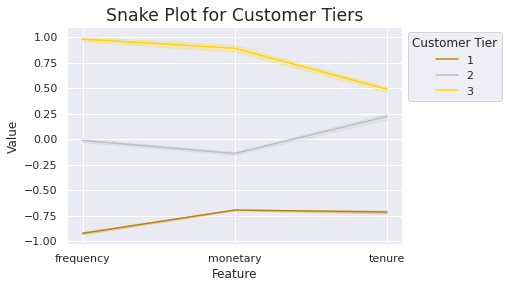

In [11]:
def snake_plot(segment_df, feats=['frequency', 'monetary', 'tenure'],
               normalize=True, segment_col='tier', user_col='user_id',
               title='Snake Plot', legend_title='Customer Tier', palette=None):
    
    '''
    Create a snake plot for the specified features of customer segments.
    
    Args:
        (1) segment_df (Pandas dataframe) - user data with defined segments
        (2) feats (list[str]) - names of columns to plot
        (3) normalize (bool) - whether to normalize the data before plotting
        (4) segment_col (str) - name of segment column
        (5) user_col (str) - name of user ID column
        (6) title (str) - plot name
        (7) legend_title (str) - legend name
        (8) palette (list[str] or str) - named color palette or list of colors for bars
        
    Returns: None.
    '''
    
    # Set index
    if user_col in segment_df.columns:
        segment_df.set_index(user_col, inplace=True)
        
    # Normalize values
    if normalize:
        df = pd.DataFrame(StandardScaler().fit_transform(segment_df[feats]), index=segment_df.index, columns=feats)
        df[segment_col] = segment_df[segment_col]
    else:
        df = segment_df[feats]
        
    # Melt features
    melt = pd.melt(df.reset_index(),
                   id_vars=[user_col, segment_col], value_vars=feats,
                   var_name='Feature', value_name='Value')

    # Create a snake plot for customer segments
    title += ' for ' + legend_title + 's'
    sns.lineplot(data=melt, x='Feature', y='Value', hue=segment_col, palette=palette)
    plt.title(title, fontsize='x-large')
    plt.legend(title=legend_title, bbox_to_anchor=(1, 1))
    plt.show()
    
    
# Snake plot
snake_plot(fmt, palette=['darkgoldenrod', 'silver', 'gold'])

##### The FMT values were reduced to quantiles in order to score each customer. The number of quantiles chosen for each feature was the weight for which the segmentation was based on:
- `Frequency` - 6 quantiles (1 - 6 points)
- `Monetary value` - 8 quantiles (1 - 8 points)
- `Tenure` - 3 quantiles (1 - 3 points)
- Example: a user in the top quantile for all 3 features would get a total score of 17 (6 + 8 + 3)

##### The weights were chosen somewhat arbitrarily, but the general idea is that monetary value is the most important feature here since it is the main focus of this project. This is followed by frequency and then tenure, which would both have more weight if we were focusing on how customers are using the app, but this is not the case.

##### The individual scores for each were summed up for a maximum of 17 points, which created 15 cohorts of users (3 - 17 points). Since there are too many cohorts and the cohort sizes weren't very balanced, I grouped the cohorts in 3 tiers of customers: `bronze` customers have a total score between 3 and 7, `silver` between 8 and 12, and `gold` between 13 and 17. 

##### As seen in the snake plot above, the average of all 3 FMT metrics increase with an increasing customer tier, although not at the same rate. The different increasing rates could be due to or made more pronounced by the difference in the number of quantiles between the features.

### <a id="rfmt3">3. Completion rate of customer tiers</a>

In [12]:
# Merge FMT data into offer events
offers = pd.merge(offers, fmt.reset_index()[['user_id', 'frequency', 'monetary', 'tenure', 'customer_tier']], on='user_id', how='left')

# Extract true offers
true_offers = offers.query('event == "offer received" and group != 3')
print(true_offers.shape)
true_offers.head(2)

(55004, 30)


index           event  time  offer_id  user_id  amount  reward  difficulty  \
0      0  offer received     0         7        2     0.0       5           5   
1      2  offer received     0         5        3     0.0       2          10   

   duration offer_type  ...  income  signup_date  signup_year  age_group  \
0         7       bogo  ...  100000   2017-05-09         2017          5   
1         7   discount  ...   70000   2018-04-26         2018          4   

  income_group  spend_group  frequency  monetary tenure  customer_tier  
0            5            8          7    159.27     15         Silver  
1            3            4          3     57.73      4         Bronze  

[2 rows x 30 columns]

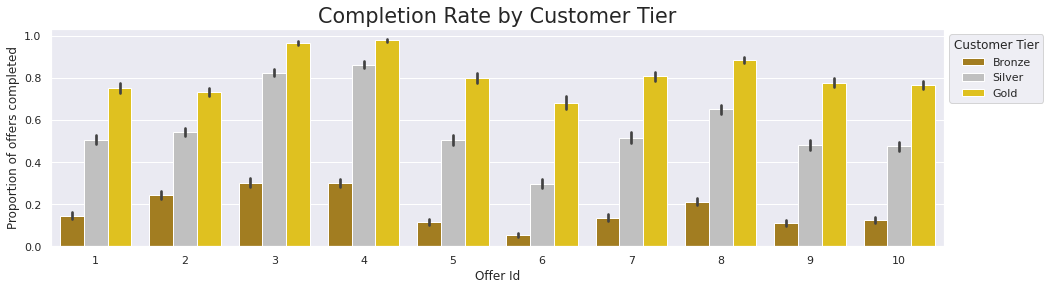

In [13]:
def plot_segment_completion(data, hue, hue_order, x='offer_id', y='completed', palette=None):
    
    '''
    Plot offer completion rate by customer segment.
    
    Args:
        (1) data (Pandas dataframe) - data to plot
        (2) hue (str) - name of segment feature column
        (3) hue_order (list) - order of hue values
        (4) x (str) - name of offer ID column
        (5) y (str) - name of completed indicator column
        (6) palette (list[str] or str) - named color palette or list of colors for bars
        
    Returns: None.
    '''
    
    title = hue.replace("_", " ").title()
    plt.figure(figsize=(16, 4))
    sns.barplot(data=data, x=x, y=y, hue=hue, hue_order=hue_order, palette=palette)
    plt.title(f'Completion Rate by {title}', fontsize='xx-large')
    plt.ylabel('Proportion of offers completed')
    plt.xlabel(x.replace('_', ' ').title())
    plt.legend(title=title, bbox_to_anchor=(1, 1))
    plt.show()
    

plot_segment_completion(true_offers, 'customer_tier', ['Bronze', 'Silver', 'Gold'],
                        palette=['darkgoldenrod' ,'silver', 'gold'])

##### Summary:
- `Bronze` customers - had a very low completion rate for all offers
    - The highest rate wasn't even as high as 40% and that was with the 2 easiest reward offers (3 and 4)
- `Silver` customers - was in between `bronze` and `gold` customers for all offers
    - Completion rate was mediocre for all offers except offers 3 and 4, which were both over 80%
- `Gold` customers - had a completion rate of over 60% for all offers
    - Completion rate gets as high as 97%
- Offers 6 had the lowest completion rate and offers 3 and 4 had the highest completion rate for all 3 tiers
    - All 3 of these were discount offers

### <a id="rfmt4">4. Customer tier demographics</a>

In [14]:
# Merge user data into FMT data
fmt = pd.merge(fmt.reset_index(), profile, on='user_id', how='left')
fmt.head(2)

user_id  frequency  monetary  tenure  F  M  T  FMT  score  tier  \
0        1          3     77.01      13  1  4  2  142      7     1   
1        2          7    159.27      15  3  6  2  362     11     2   

  customer_tier gender  age  income signup_date  signup_year  age_group  \
0        Bronze      F   55  112000  2017-07-15         2017          3   
1        Silver      F   75  100000  2017-05-09         2017          5   

   income_group  amount  spend_group  
0             5   77.01            5  
1             5  159.27            8

In [15]:
def plot_user_demographics(user_df, title='User Demographics', height=250, width=1000,
                           gender_col='gender', age_col='age', income_col='income'):
    
    '''
    Plot the distribution of user demographics - `gender`, `age`, and `income`.
    
    Args:
        (1) user_df (Pandas dataframe) - user data
        (2) title (str) - plot title
        (3) height (int) - figure height
        (4) width (int) - figure width
        (5) gender_col (str) - name of gender column
        (6) age_col (str) - name of age column
        (7) income_col (str) - name of income column
        
    Returns: None
    '''
    
    fig = subplots.make_subplots(1, 3, horizontal_spacing=0.05, y_title='Number of users',
                                 subplot_titles=['Gender', 'Age', 'Income'])
    fig.add_trace(go.Histogram(x=user_df[gender_col].sort_values(), name='Gender'), 1, 1) # gender
    fig.add_trace(go.Histogram(x=user_df[age_col], name='Age'), 1, 2) # age
    fig.add_trace(go.Histogram(x=user_df[income_col], name='Income'), 1, 3) # income
    fig.update_layout(title=title, height=height, width=width, 
                      margin=dict(t=80, r=0, b=0, l=80), showlegend=False)
    fig.show()
    

# Plot user demographics for each customer tier
tier_demo = []
for t in ['Bronze', 'Silver', 'Gold']:
    fmt_tier = fmt[fmt.customer_tier == t]
    tier_demo.append([fmt_tier.shape[0], int(fmt_tier.age.mean()), fmt_tier.income.mean().round(2)])
    plot_user_demographics(fmt_tier, title=f'{t} Customer Demographics')
pd.DataFrame(tier_demo, index=range(1, 4), columns=['n_users', 'avg_age', 'avg_income'])

n_users  avg_age  avg_income
1     4833       52    60382.79
2     5372       55    66598.85
3     4620       54    69270.56

In [16]:
del ref_date, true_offers, tier_demo, fmt_tier, t
gc.collect()

11856

##### With an increasing customer tier, we can see the following changes:
- `Gender` - proportion of female users increases relative to male users
    - In the `bronze` group, there are more than twice as many male users as female users
    - In the `gold` group, the number of female and male users are almost equal
- `Age` - number of users under 40 decreases
    - But there isn't much difference in the average age
- `Income` - number of lower earners decreases and number of higher earners increase
    - The average income of `gold` users is about 9k higher than the average income of `bronze` users

##### As `bronze` users do not spend a lot of money, they're not very likely to respond to offers so it would be a good idea to either stop sending them offers or to only send them offers that are easy to complete.

##### `Silver` users do spend quite a bit more than `bronze` users, so it's actually worth it to be sending them offers. They completed a good portion of discount offers 3 and 4 that were sent out, so focusing on the easier offers or lowering the difficulty of the harder offers would likely result in an increase the number of offers that are completed.

##### `Gold` users consistently have a high rate of offer completion so it would actually benefit Starbucks to increase the difficulty of offers being sent to these users. As they are highly likely to respond to offers, a higher difficulty would likely increase the amount these customers spend.

## <a id="clus">Section III: Cluster Segmentation</a>

### <a id="clus0">0. Data preparation</a>

In [17]:
# def norm_transform(df, cols=['age', 'income', 'frequency', 'monetary', 'tenure'], scaler=None):
    
#     '''
#     Transform data to make every column normally distributed or inverse-transform
#     transformed data to original data.
#     Transformation process:
#         (1) Scale data to range between 0.01 and 0.99
#             - The transformation curve is undefined for negative values, 0, and
#               values greater than or equal to 1
#         (2) T = log(D / (1 - D))
#             - Where T is the transformed data and D is the original data
    
#     Args:
#         (1) df (Pandas dataframe) - data to transform
#         (2) cols (list[str]) - names of columns to include
#         (3) scaler (Sklearn scaler) - scaler to inverse-scale with if performing inverse-transforming
#                                       or none if performing regular transformation
        
#     Returns:
#         (1) Transformed data (Pandas dataframe).
#         (2) Min-max scaler (Sklearn scaler).
#     '''
    
#     if scaler is None: # transform
#         scaler = MinMaxScaler(feature_range=(0.01, 0.99))
#         transformed = pd.DataFrame(scaler.fit_transform(df[cols]), columns=cols) # scale for transformation
#         for col in cols:
#             transformed[col] = transformed[col].apply(lambda f: np.log(f / (1 - f)))
#         return transformed, scaler
    
#     else: # inverse-transform
#         original = pd.DataFrame()
#         for col in cols:
#             original[col] = df[col].apply(lambda f: np.exp(f))
#             original[col] = original[col].apply(lambda f: f / (1 + f))
#         original = pd.DataFrame(scaler.inverse_transform(original), columns=cols).astype(int) # inverse-scale
#         return original, scaler
        
        
# # Transform features into a normal distribution and normalize the values
# feats = ['age', 'income', 'frequency', 'monetary', 'tenure']
# dem_transformed, MMscaler = norm_transform(fmt[feats])
# Sscaler = StandardScaler()
# dem_scaled = pd.DataFrame(Sscaler.fit_transform(dem_transformed), columns=feats)
# dem_scaled.head(2)

In [18]:
# # Plot distributions and QQ plots
# fig, ax = plt.subplots(5, 2, sharex=True, figsize=(12, 15))
# fig.suptitle('Distributions and QQ Plots', fontsize='x-large')

# for i in range(5):
#     feat = dem_scaled.iloc[:, i]
#     feat.plot(kind='hist', bins=20, ax=ax[i, 0], title=dem_scaled.columns[i].title())
#     sm.qqplot(feat, loc=feat.mean(), scale=feat.std(), line='s', ax=ax[i, 1])
#     plt.xlim(-4, 4)

### <a id="clus1">1. Principal Component Analysis (PCA)</a>

In [19]:
# Group "female" and "other" gender into a new binary feature
fmt['male'] = (fmt.gender == 'M').astype(int)
fmt.head(2)

user_id  frequency  monetary  tenure  F  M  T  FMT  score  tier  ...  \
0        1          3     77.01      13  1  4  2  142      7     1  ...   
1        2          7    159.27      15  3  6  2  362     11     2  ...   

  gender age  income  signup_date signup_year  age_group  income_group  \
0      F  55  112000   2017-07-15        2017          3             5   
1      F  75  100000   2017-05-09        2017          5             5   

   amount  spend_group  male  
0   77.01            5     0  
1  159.27            8     0  

[2 rows x 21 columns]

array([0.28691816, 0.26401487, 0.14821769, 0.13255764, 0.11507985])

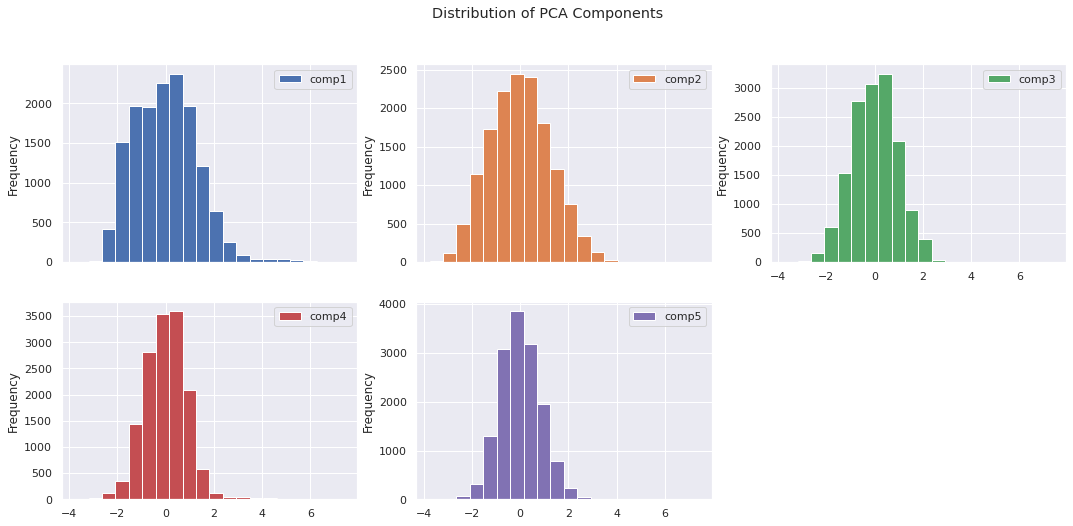

In [20]:
# Normalize features
scaler = StandardScaler()
scaled = scaler.fit_transform(fmt[['male', 'age', 'income', 'frequency', 'monetary', 'tenure']])

# PCA
pca = PCA(n_components=5, random_state=0)
user_pca = pd.DataFrame(pca.fit_transform(scaled), columns=['comp' + str(i) for i in range(1, 6)])
user_pca.plot(kind='hist', bins=20, figsize=(18, 8), subplots=True, layout=(2, 3),
                   title='Distribution of PCA Components')

# Add components to FMT data
fmt = pd.concat([fmt, user_pca], axis=1)
pca.explained_variance_ratio_

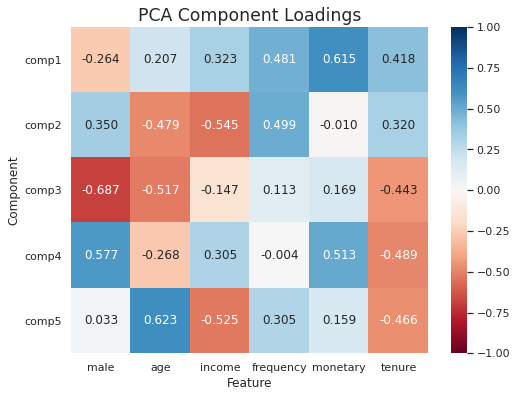

In [21]:
def heatmap(data, title, ylabel, xlabel='Feature', vmin=-1, vmax=1, cmap='RdBu'):
    
    '''
    Plot a heatmap.
    
    Args:
        (1) data (Pandas dataframe) - data to plot
        (2) title (str) - plot name
        (3) xlabel (str) - x-axis name
        (4) ylabel (str) - y-axis name
        (5) vmin (int or float) - colorbar minimum
        (6) vmax (int or float) - colorbar maximum
        (7) cmap (str) - named color palette
        
    Returns: None.
    '''
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(data, annot=True, vmin=vmin, vmax=vmax, cmap=cmap, fmt='.3f')
    plt.title(title, fontsize='x-large')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.yticks(rotation=0)
    plt.show()
    

# PCA component loadings
user_comps = pd.DataFrame(pca.components_, index=user_pca.columns,
                         columns=['male', 'age', 'income', 'frequency', 'monetary', 'tenure'])
heatmap(user_comps, 'PCA Component Loadings', 'Component')

##### `Gender` was reduced to a binary feature that indicates whether the user is male because there is a very low number of "other" users so they were grouped with "female" users to represent non-male users. Since this is still a categorical feature and K-means clustering wasn't meant for categorical features, I used PCA to get new components (which are linear combinations of the original features) to perform clustering with. The 5 components account for almost 95% of the explained variance.

##### I will attempt to characterize each component based on its loadings. These characterizations may not capture the entire essence of the component, but can give a general idea.
1. `Component 1` - high spending amount
2. `Component 2` - low income, high spending frequency
3. `Component 3` - female, young, newer to the app
4. `Component 4` - male, high spending amount, newer to the app
5. `Component 5` - older, lower income, newer to the app

### <a id="clus2">2. K-means clustering</a>

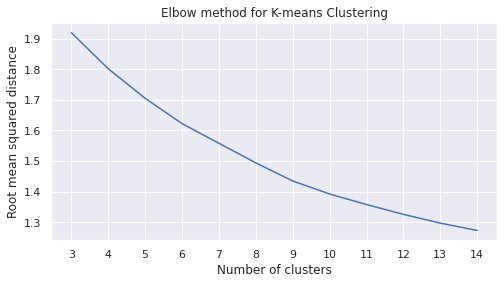

In [22]:
# Test different numbers of clusters
msd = [] # mean
for k in range(3, 15):
    kmeans = KMeans(k, random_state=0)
    kmeans.fit(user_pca)
    msd.append(np.sqrt(kmeans.inertia_ / user_pca.shape[0]))
    
# Elbow method
plt.figure(figsize=(8, 4))
sns.lineplot(x=range(3, 15), y=msd)
plt.title('Elbow method for K-means Clustering')
plt.ylabel('Root mean squared distance')
plt.xlabel('Number of clusters')
plt.xticks(range(3, 15), range(3, 15));

In [23]:
# K-means clustering
kmeans = KMeans(4, random_state=0)
kmeans.fit(user_pca)
fmt['cluster'] = kmeans.labels_

# Cluster summary
feats = ['male', 'age', 'income', 'frequency', 'monetary', 'tenure', 'comp1', 'comp2', 'comp3', 'comp4', 'comp5']
cluster_means = segment_means(fmt, feats, 'cluster')
cluster_means

male    age    income  frequency  monetary  tenure  comp1  comp2  \
cluster                                                                     
0        0.00  58.43  70343.42       5.47     85.41   12.65  -0.12  -1.00   
1        0.75  46.72  51993.22      12.79    116.70   32.34   0.54   1.52   
2        0.45  63.56  87546.26      10.25    292.02   23.20   1.73  -0.54   
3        1.00  51.65  59063.12       4.77     47.83    8.69  -1.26   0.02   

         comp3  comp4  comp5  n_users  pct_users  
cluster                                           
0         0.71  -0.60  -0.02     4030      27.18  
1        -0.26  -0.38  -0.11     3538      23.87  
2        -0.14   0.54  -0.03     2583      17.42  
3        -0.34   0.51   0.12     4674      31.53

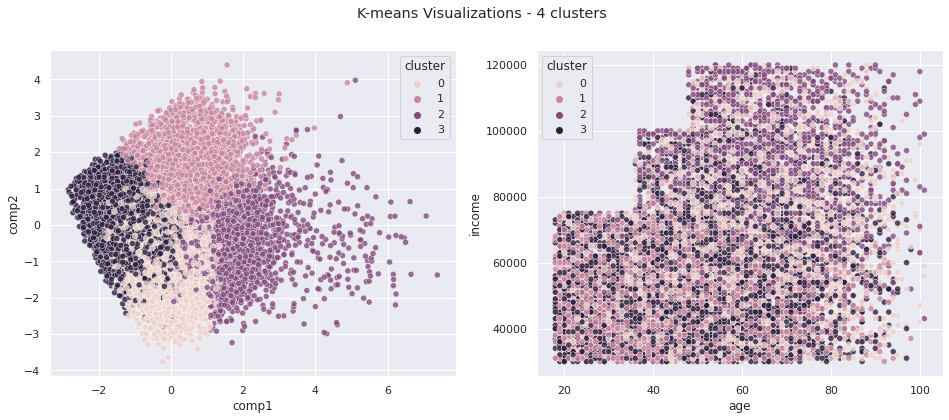

In [24]:
# Visualize clusters
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.scatterplot(data=fmt, x='comp1', y='comp2', hue='cluster', ax=ax[0], alpha=0.8) # first 2 components
sns.scatterplot(data=fmt, x='age', y='income', hue='cluster', ax=ax[1], alpha=0.8); # age vs income
fig.suptitle('K-means Visualizations - 4 clusters');

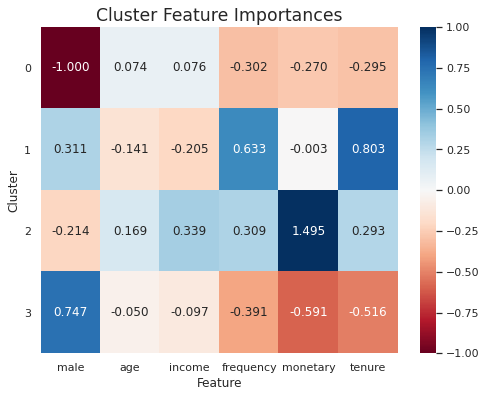

In [25]:
# Feature importances of
feats = ['male', 'age', 'income', 'frequency', 'monetary', 'tenure']
overall_means = fmt[feats].mean()
feat_importances = cluster_means.iloc[:, :6] / overall_means - 1
heatmap(feat_importances, 'Cluster Feature Importances', 'Cluster')

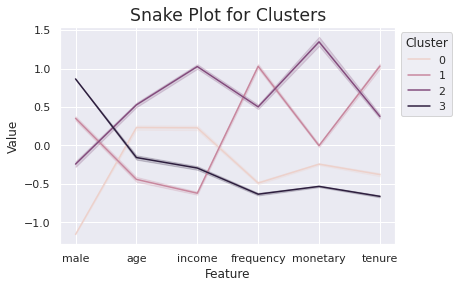

In [26]:
# Snake plot
snake_plot(fmt, feats, segment_col='cluster', legend_title='Cluster')

In [27]:
fmt['customer_cluster'] = fmt.cluster.map({0: 'Female low spenders',
                                           1: 'Low earners',
                                           2: 'High earners',
                                           3: 'Male low spenders'})
fmt.head(2)

frequency  monetary  tenure  F  M  T  FMT  score  tier customer_tier  \
user_id                                                                         
1                3     77.01      13  1  4  2  142      7     1        Bronze   
2                7    159.27      15  3  6  2  362     11     2        Silver   

         ...  amount  spend_group  male     comp1     comp2     comp3  \
user_id  ...                                                            
1        ...   77.01            5     0  0.190966 -2.206539  0.450535   
2        ...  159.27            8     0  1.096733 -2.001638  0.074636   

            comp4     comp5  cluster     customer_cluster  
user_id                                                    
1        0.000317 -1.337460        0  Female low spenders  
2       -0.226534 -0.042568        0  Female low spenders  

[2 rows x 27 columns]

##### Using the elbow method, I initially decided to create 9 clusters. But with 9 clusters, the cluster sizes were imbalanced, some of the clusters had similar demographics, and there was no clear line of separation. After trying several values, I found 4 clusters to be optimal because the clusters were distinguishable and more interpretable.

##### The main identifying characteristics for each cluster are:
- `Cluster 0` - gender (-)
- `Cluster 1` - frequency (+) and tenure (+)
- `Cluster 2` - monetary value (+)
- `Cluster 3` - gender (+), monetary value (-), and tenure (-)

##### The clusters were named using the snake plot. The general description of each cluster is as follows:
- `Cluster 0` (female low spenders) - users in this group are predominantly female with average to slightly above average age and income, and do not spend very much money
    - There is a small number of "other" users and no male users
- `Cluster 1` (low earners) - users in this group are younger and are low earners, who spend frequently but in small amounts
- `Cluster 2` (high earners) - users in this group are older and have the highest income compared to the other clusters, who also spend the most money
- `Cluster 3` (male low spenders) - users in this group are all male with average to a little below average age and income, and spend the least compared to the other clusters

### <a id="clus3">3. Cluster demographics</a>

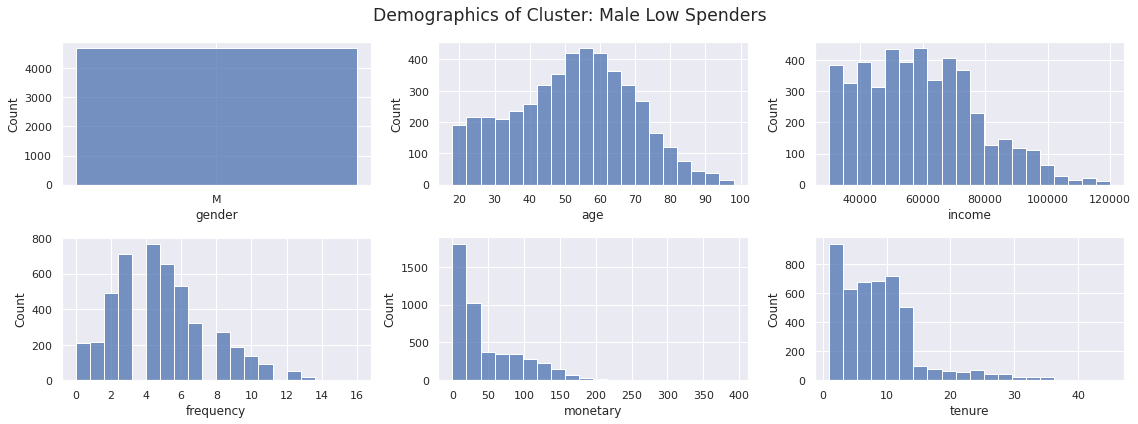

In [28]:
def plot_user_demographics6(segment_df, segment, color,
                            cols=['gender'] + feats[1:], 
                            segment_col='customer_cluster'):
    
    '''
    Plot the distribution of user demographics and FMT features in a segment.
    
    Args:
        (1) segment_df (Pandas dataframe) - data with defined segments
        (2) segment (str or int) - name of segment
        (3) color (tuple(float, float, float) or str) - RGB tuple or named color for bars
        (3) cols (list[str]) - names of cols to plot
        (4) segment_col (str) - name of segment column
    
    Returns: None.
    '''
    
    # Extract cluster
    cluster = segment_df.loc[segment_df[segment_col] == segment, cols]
    
    # Histogram subplots
    fig, ax = plt.subplots(2, 3, figsize=(16, 6))
    fig.suptitle('Demographics of Cluster: ' + segment.title(), fontsize='x-large')
    for i in range(3):
        sns.histplot(cluster[cols[i]], bins=20, color=color, ax=ax[0, i])
        sns.histplot(cluster[cols[i + 3]], bins=20, color=color, ax=ax[1, i])
    plt.tight_layout()
    

# Demographics of male low spenders
plot_user_demographics6(fmt, 'Male low spenders', sns.color_palette()[0])

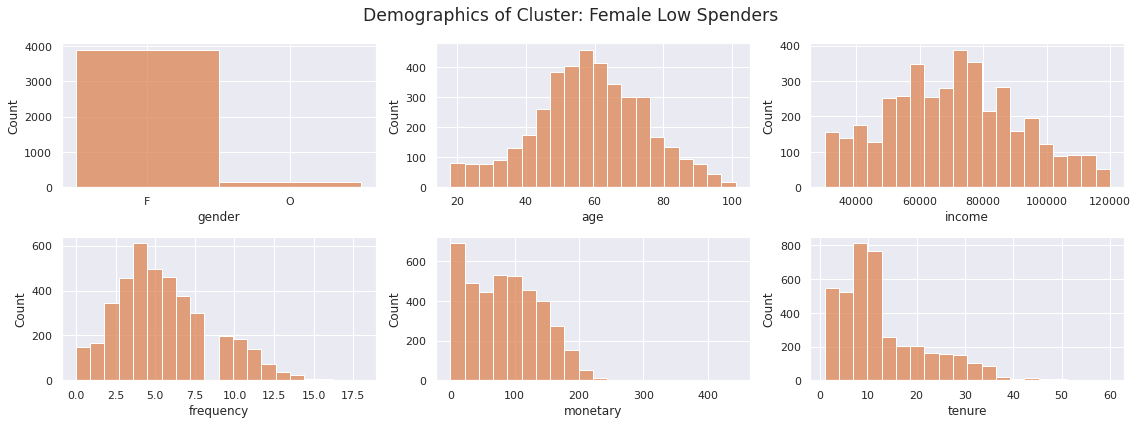

In [29]:
# Demographics of female low spenders
plot_user_demographics6(fmt, 'Female low spenders', sns.color_palette()[1])

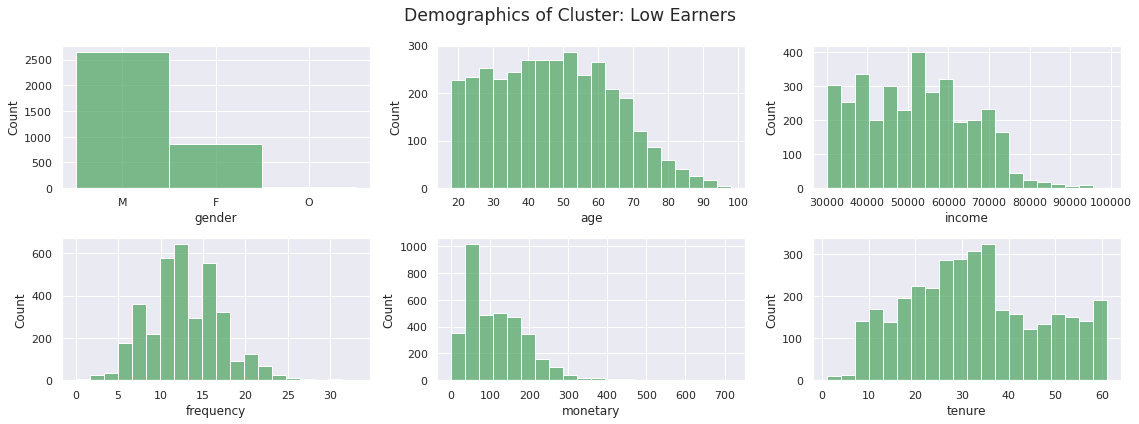

In [30]:
# Demographics of low earners
plot_user_demographics6(fmt, 'Low earners', sns.color_palette()[2])

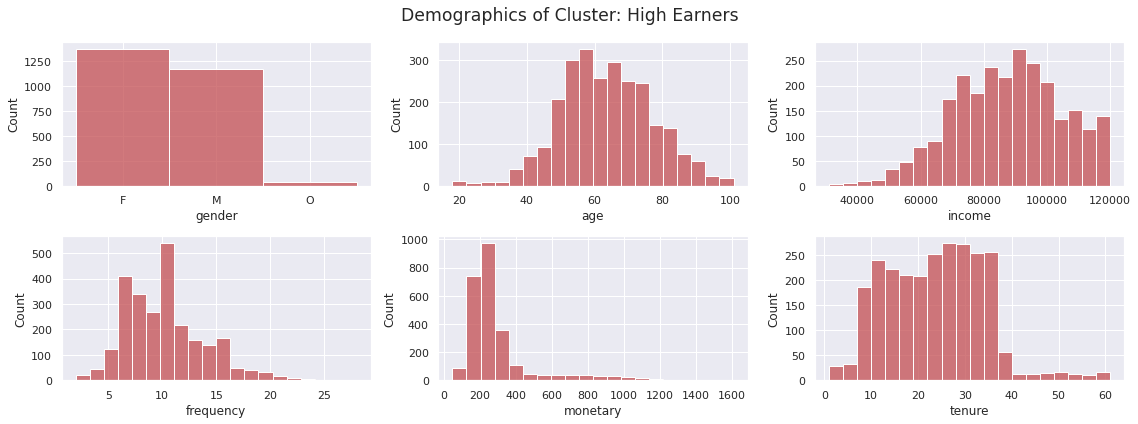

In [31]:
# Demographics of high earners
plot_user_demographics6(fmt, 'High earners', sns.color_palette()[3])

##### 1. `Male low spenders`
- This group is entirely male and contains a lot of users under the age of 40 relative to the other groups
- Has the most number of users with an income less than 80k
    - This group has even more low earners than the `low earners` group, but also has more higher earners to pull their average income higher than the `low earners` group *
- Users in this group spend the least money relative to the other groups
- Most users in this group have been using the app for less than a year **

##### 2. `Female low spenders`
- Except a few other-gendered users, this group is entirely female
- Age and income are both roughly normally distributed with means a little above the overall means
- Users in this group also do not spend a lot of money, despite having an average income that is higher than the overall mean
- Again, most users in this group have been using the app for less than a year, with some in the 2 and 3 year marks **

##### 3. `Low earners`
- There are 3 times as many male as female users
- This group contains the most younger users
- Most users in this group have a salary of less than 75k
- Users in this group spend money frequently but have a low total amount, which means they are making many small transactions
- Most users in this group have been using the app for more than a year **

##### 4. `High earners`
- There are a little more female than male users
- There is a very low number of users under the age of 40
- Most users in this group have a salary of more than 70k
- Users in this group don't spend as frequently as the `low earners`, but spend the most money relative to the other groups
- Most users in this group have been using the app between 1 and 3 years **


\* Note: clusters were named based on the snake plot, which displays average values.<br/>
\** Note: tenure was recorded as the number of months between the user's signup date and the reference date (which is 30 days after the latest signup date in the data)

### <a id="clus4">4. Completion rate of clusters</a>

In [32]:
# Merge cluster data into offer events
offers = pd.merge(offers, fmt.reset_index()[['user_id', 'cluster', 'customer_cluster']], on='user_id', how='left')

# Extract true offers
true_offers = offers.query('event == "offer received" and group != 3')
print(true_offers.shape)
true_offers.head(2)

(55004, 32)


index           event  time  offer_id  user_id  amount  reward  difficulty  \
0      0  offer received     0         7        2     0.0       5           5   
1      2  offer received     0         5        3     0.0       2          10   

   duration offer_type  ...  signup_year  age_group  income_group  \
0         7       bogo  ...         2017          5             5   
1         7   discount  ...         2018          4             3   

   spend_group frequency  monetary  tenure  customer_tier cluster  \
0            8         7    159.27      15         Silver       0   
1            4         3     57.73       4         Bronze       3   

      customer_cluster  
0  Female low spenders  
1    Male low spenders  

[2 rows x 32 columns]

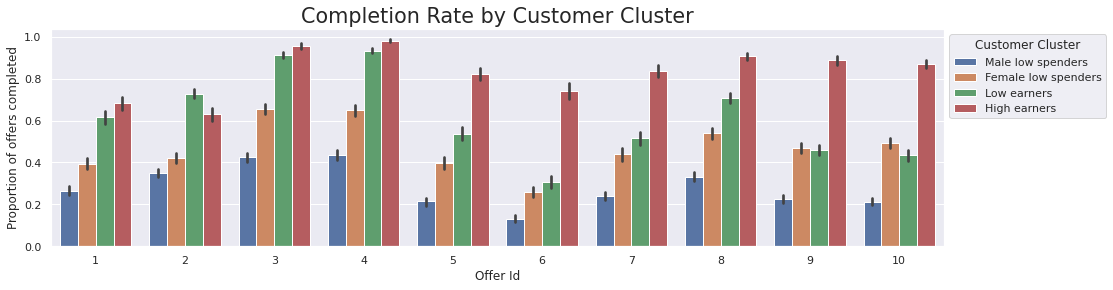

In [33]:
# Plot completion rate by cluster
plot_segment_completion(true_offers, hue='customer_cluster',
                        hue_order=true_offers.groupby('customer_cluster').monetary.mean().sort_values().index)

In [34]:
del scaler, scaled, pca, user_pca, user_comps, \
    overall_means, cluster_means, feat_importances, \
    true_offers, feats, fig, ax, msd, k, \
    # dem_transformed, MMscaler, dem_scaled, Sscaler, feat, i
gc.collect()

37497

##### In the barplot above, the customer clusters were ordered based on their average monetary value, i.e. `male low spenders` spent the least and `high earners` spent the most money. We can see for most offers that as a group's average spending increases, so does the rate at which they complete offers.

##### The completion rates of `male low spenders`, `low earners` and `high earners` look similar to those of the `bronze`, `silver`, and `gold` tiers from the FMT segmentation respectively. So the same suggestions would apply to these clusters.

## <a id="summ">Section IV: Summary</a>

##### In this notebook, I used 2 different methods to segment customers:
1. [Quantile segmentation with frequency, monetary value, and tenure (FMT)](#rfmt) - this method focused primarily on the spending behavior of customers on the app and created segments based on the number of transactions made during the month, the total amount spent during the month, and how long the customer has been using the app
2. [K-means clustering](#clus) - this method combined user demographic with FMT features and created clusters from linear combinations of these features
    - The features were not used directly with K-means clustering because one of the demographic features (`gender`) is categorical
    - Principal component analysis (PCA) was used to create 5 components (which are linear combinations of the features) that explained almost 95% of the variance in the data
    
##### The segmentation analysis from both methods revealed several key insights, some of which were also seen in the exploratory analysis from the previous notebook (`1-analysis.ipynb`). We made the following observations and inferences based on the analysis:
- Female users tend to spend more money than male users, given they are in the same age group or income group
- Younger users tend to make frequent but small transactions on the app
- As income increases, spending increases
- As age increases, both income and spending showed a very similar pattern for both genders: they increased up to a certain age (mid-50s) then leveled off and became flat from then on
- The more users spend, the more likely they are to respond to offers
- The longer users have been using the app, the more comfortable they are spending money on it

##### Based on the customers' spending habits, I would suggest:
1. Target the low spenders with the easier offers and lower the difficulty of the more difficult offers because they are currently not responding as much to the more difficult offers
2. Send the high spenders more informational offers and raise the difficulty of their reward offers (discount and bogo), since they are much more likely to respond to most offers

##### The next notebook (`3-modeling.ipynb`) will focus on predictive modeling.

### Save data

In [35]:
profile.to_pickle('../data/out2/profile.pkl') # user data
transcript.reset_index().to_pickle('../data/out2/transcript.pkl') # event data
offers.to_pickle('../data/out2/offers.pkl') # transcript of offer-related events
fmt.to_pickle('../data/out2/fmt.pkl') # FMT data
joblib.dump(kmeans, '../data/out2/kmeans4.pkl')
profile.shape, transcript.shape, offers.shape, fmt.shape

((14825, 10), (272388, 7), (148431, 32), (14825, 27))